In [89]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.family': 'serif'})

import ipywidgets as widgets
from IPython.display import display
from matplotlib.widgets import Button, Slider
from ipywidgets import interact, IntSlider

%matplotlib ipympl
from ipywidgets import interact
from mpl_interactions import ipyplot as iplt

import math
from scipy.stats import dirichlet, norm, truncnorm, uniform, expon

from collections import OrderedDict

from trails.mtmc.ml.direct.optimized import log_ml
from trails.mtmc.common import calc_mixed_hypothesis
import trails.transition_probabilities as tp
import trails.randomwalk.randomwalk as rw
import trails.randomwalk.next_state as next_state
import trails.randomwalk.keep_walking as keep_walking
import trails.randomwalk.first_state as first_state
import trails.group_assignment as group_assignment
import trails.mtmc.common as common
import trails.utils as utils
import trails.plot as pl
import trails.mtmc.ml.deterministic.default as deterministic

from metropolis_hastings.mh_algo import metropolis_hastings

In [79]:
import pickle

import trails.hyptrails as ht
from scipy.sparse import csr_matrix

from collections import OrderedDict


import numpy as np
import trails.mtmc.ml.deterministic.default as deterministic

import sys

# settings

n_states = 4604
ks = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000, 300000, 1000000, 3000000, 10000000, 30000000, 100000000]

# load transitions
with open("tmp/wikispeedia-transitions.p", "rb") as f:
    transitions = pickle.load(f)
n_transitions = transitions.shape[0]    

# load cosine hypothesis
with open("tmp/wikispeedia-hyp_cos.p", "rb") as f:
    hyp_cos = pickle.load(f)

# load degree hypothesis
with open("tmp/wikispeedia-hyp_deg.p", "rb") as f:
    hyp_deg = pickle.load(f)

hyp_links = hyp_cos.copy()
hyp_links.data[:] = 1
sums = hyp_links.sum(axis=1)
sums[sums == 0] = 1
hyp_links = csr_matrix(hyp_links / sums)

hyp_deg_cos = np.array([hyp_deg.toarray(), hyp_cos.toarray()])
hyp_deg_cos_link = np.array([hyp_deg.toarray(), hyp_cos.toarray(), hyp_links.toarray()])

In [77]:
transitions.shape

(130003, 2)

In [16]:
# mixed trails specific function to calculate the values for the current state needed to calculate the acceptance ratio
def calc_values(curr_state, kappa=1000, smoothing=1, n_samples=10):
    group_assignment_p_curr = np.repeat(np.array([curr_state]), n_random_walkers * n_steps, axis=0)
    alpha_curr = calc_mixed_hypothesis(group_assignment_p_curr, hyp_groups_homo)
    log_likelihood_curr = log_ml(transitions, group_assignment_p_curr, alpha_curr * kappa, smoothing=smoothing, n_samples=n_samples)

    return log_likelihood_curr, prior.pdf(curr_state)

# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=20, c2=20):
    proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state))  
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, proposed_state * c2) / dirichlet.pdf(proposed_state, curr_state * c2)
    return proposed_state, proposal_ratio

In [17]:
import trails.mtmc.ml.direct.optimized as directo

kappas_base = [0, 0.001,0.003, 0.01, 0.03, 0.1, 0.3,1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,1000000]

def run_exp(group_assignment_p, hyp, data):
    return {"x": kappas_base, "y": [directo.log_ml(
        transitions = data, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * k for a in hyp]),
        smoothing = 1,
        n_samples = 10) for k in kappas_base]}

def run_exp2(group_assignment_p, hyp, data, kappa):
    return directo.log_ml(
        transitions = data, 
        group_assignment_p = group_assignment_p, 
        alpha = np.array([a * kappa for a in hyp]),
        smoothing = 1,
        n_samples = 10)

In [70]:
ps = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

experiments = OrderedDict()
for p in ps:
    p_dist = np.array([np.round(p, 2), np.round(1-p, 2)])
    group_assignment_p = np.repeat(np.array([p_dist]), n_transitions, axis=0)  
    experiments[f"s={p_dist}"] = run_exp(group_assignment_p, common.calc_mixed_hypothesis(group_assignment_p, hyp_deg_cos), transitions)

            
#experiments["ground truth assignment"] = run_exp(group_assignment_p_gt, common.calc_mixed_hypothesis(group_assignment_p_gt, hyp_groups_homo), transitions)

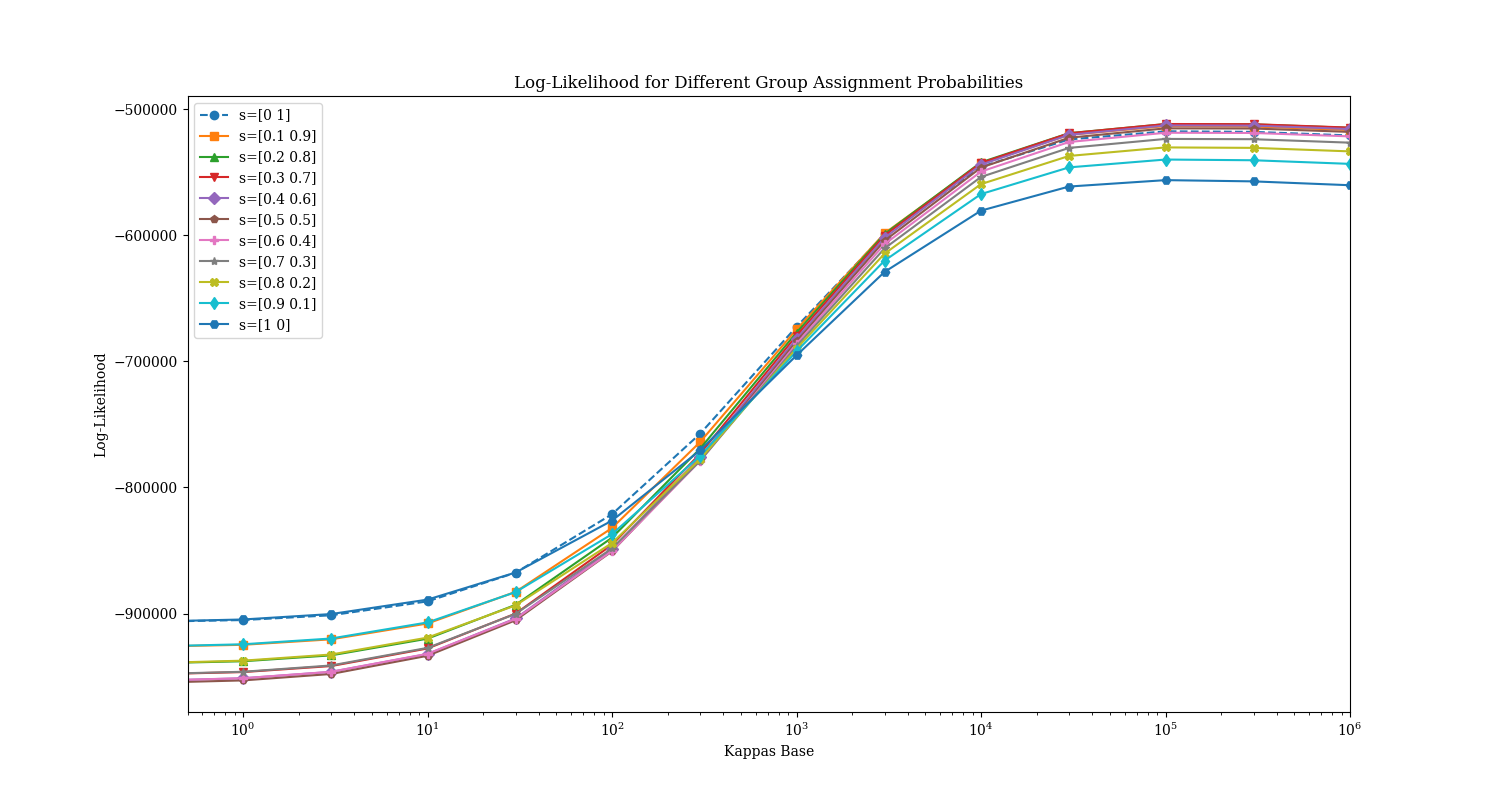

In [74]:
import matplotlib.pyplot as plt
plt.close()
plt.rcParams['figure.figsize'] = 15, 8

markers = ['o', 's', '^', 'v', 'D', 'p', 'P', '*', 'X', 'd', 'H', '<', '>']
line_style = ['dashed'] + 10*['solid'] + ['dotted']

for idx, (key, data) in enumerate(experiments.items()):
    plt.semilogx(data['x'], data['y'], marker=markers[idx % len(markers)], linestyle=line_style[idx % len(line_style)], label=key)  # Plot 'x' vs 'y' using the current key as the label

plt.xlim(0.5, max(data['x']))
#plt.ylim(-36000, -28000)
plt.xlabel('Kappas Base')  # Set X-axis label
plt.ylabel('Log-Likelihood')  # Set Y-axis label
plt.title('Log-Likelihood for Different Group Assignment Probabilities')  
plt.legend() 

import tikzplotlib

tikzplotlib.save("test.tex") 

# Metropolis

# hyp_cos

In [67]:
# mixed trails specific function to calculate the values for the current state needed to calculate the acceptance ratio
def calc_values(curr_state, kappa=100000, smoothing=1, n_samples=10):
    group_assignment_p_curr = np.repeat(np.array([curr_state]), n_transitions, axis=0)
    alpha_curr = calc_mixed_hypothesis(group_assignment_p_curr, hyp_deg_cos)
    log_likelihood_curr = log_ml(transitions, group_assignment_p_curr, alpha_curr * kappa, smoothing=smoothing, n_samples=n_samples)

    return log_likelihood_curr, prior.pdf(curr_state)

# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=20, c2=20):
    proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state))  
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, proposed_state * c2) / dirichlet.pdf(proposed_state, curr_state * c2)
    return proposed_state, proposal_ratio

In [62]:
# init prior distribution
a = np.array([1, 1])
prior = dirichlet(a)

In [68]:
%%time

init_state = np.random.dirichlet(np.ones(2))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 100, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array = np.array(samples)
burnin_samples_array = np.array(burnin_samples)

[0.15212437 0.84787563]
[array([0.20363256, 0.79636744]), -542002.6415558644]
6
CPU times: total: 9min 53s
Wall time: 10min 4s


# hyp_cos_link

In [84]:
# mixed trails specific function to calculate the values for the current state needed to calculate the acceptance ratio
def calc_values(curr_state, kappa=100000, smoothing=1, n_samples=10):
    group_assignment_p_curr = np.repeat(np.array([curr_state]), n_transitions, axis=0)
    alpha_curr = calc_mixed_hypothesis(group_assignment_p_curr, hyp_deg_cos_link)
    log_likelihood_curr = log_ml(transitions, group_assignment_p_curr, alpha_curr * kappa, smoothing=smoothing, n_samples=n_samples)

    return log_likelihood_curr, prior.pdf(curr_state)

# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=100, c2=100):
    proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state))  
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = dirichlet.pdf(curr_state, proposed_state * c2) / dirichlet.pdf(proposed_state, curr_state * c2)
    return proposed_state, proposal_ratio

In [82]:
# init prior distribution
a = np.array([1, 1, 1])
prior = dirichlet(a)

In [85]:
%%time

init_state = np.random.dirichlet(np.ones(3))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 300, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array = np.array(samples)
burnin_samples_array = np.array(burnin_samples)

[0.01678698 0.11068604 0.87252698]
[array([2.52179235e-01, 7.47603120e-01, 2.17645263e-04]), -511478.4598873894]
33
CPU times: total: 32min 3s
Wall time: 33min 51s


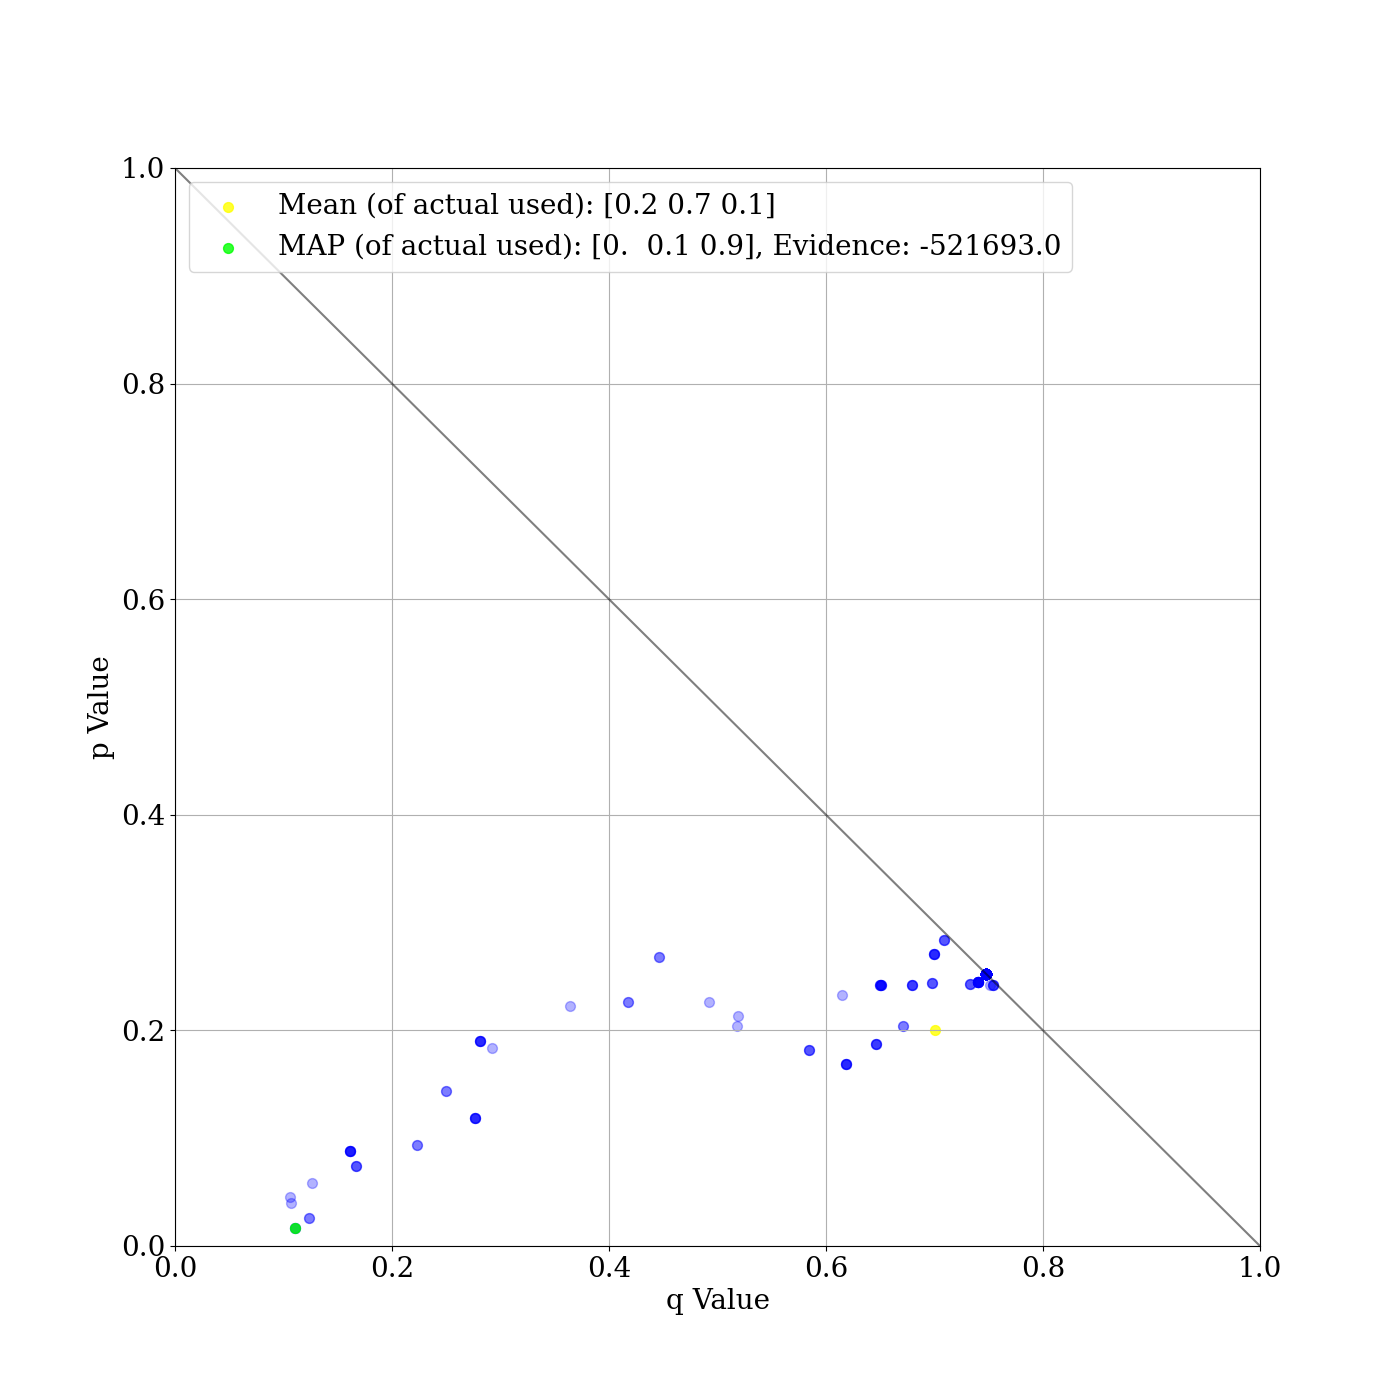

In [86]:
# Function to plot the samples with the specified index
plt.close()
fig1, ax1 = plt.subplots()
fig1.set_size_inches(14, 14)

def plot_sample(sample_index):
    sample_index = int(sample_index)

    samps = np.concatenate((burnin_samples_array, samples_array))
    ax = ax1
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.tick_params( labelsize=20)
    #ax.set_title('Samples from Metropolis-Hastings')
    ax.set_xlabel('q Value', fontsize=20)
    ax.set_ylabel('p Value', fontsize=20)
    ax.grid(True)
    

    ax.scatter(samps[:sample_index, 1], samps[:sample_index, 0], s=50, c='red', alpha=0.3)#, label=f'Sample {sample_index}')
    ax.scatter(samps[sample_index:, 1], samps[sample_index:, 0], s=50, c='blue', alpha=0.3)
    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 1)
    ax.scatter(curr_mean[1], curr_mean[0], s=50, c='yellow', alpha=0.8, label=f'Mean (of actual used): {curr_mean}')

    
    ax.scatter(map_estimate_list[sample_index][0][1], map_estimate_list[sample_index][0][0], s=50, c='lime', alpha=0.8, 
               label=f'MAP (of actual used): {np.round(map_estimate_list[sample_index][0],1)}, Evidence: {np.round(map_estimate_list[sample_index][1])}')
    
    ax.legend(loc='upper left', fontsize="20")
    ax.plot([0, 1], [1, 0], transform=ax.transAxes, c='black', alpha=0.5)
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, len(np.concatenate((burnin_samples_array, samples_array))) - 1))

# hyp_cos_link and kappa

In [91]:
# mixed trails specific function to calculate the values for the current state needed to calculate the acceptance ratio
def calc_values(curr_state, smoothing=1, n_samples=10):
    kappa = curr_state[0]
    curr_state = curr_state[1:]
    group_assignment_p_curr = np.repeat(np.array([curr_state]), n_transitions, axis=0)
    alpha_curr = calc_mixed_hypothesis(group_assignment_p_curr, hyp_deg_cos_link)
    log_likelihood_curr = log_ml(transitions, group_assignment_p_curr, alpha_curr * kappa, smoothing=smoothing, n_samples=n_samples)
    #print(log_likelihood_curr)
    return log_likelihood_curr, prior1.pdf(kappa) * prior2.pdf(curr_state)

# dirichlet proposal distribution
def dirichlet_proposal(curr_state, concentration_factor=100, c2=100):
    curr_kappa = curr_state[0]
    curr_state = curr_state[1:]
    
    scale = 500
    proposed_kappa = expon.rvs(scale=curr_kappa)
    #print(proposed_kappa)
    #proposed_kappa = norm.rvs(loc=curr_kappa, scale=scale)
    #proposed_kappa = uniform.rvs(loc=0, scale=scale)
    
    proposed_state = dirichlet.rvs(alpha=curr_state*concentration_factor, size=1).reshape(len(curr_state))  
    
    # problem: dirichlet samples with zero entries cannot be used as new parameters for the dirichlet proposal dist
    mask = (proposed_state == 0)
    proposed_state[mask] = 0.001
    counts = mask.sum()
    proposed_state[np.argmax(proposed_state)] -= counts * 0.001

    proposal_ratio = (dirichlet.pdf(curr_state, proposed_state * c2) * expon.pdf(curr_kappa, scale=proposed_kappa)) / (dirichlet.pdf(proposed_state, curr_state * c2) * expon.pdf(proposed_kappa, scale=curr_kappa))
    #proposal_ratio = (dirichlet.pdf(curr_state, proposed_state * c2) * norm.pdf(curr_kappa, loc=proposed_kappa, scale=scale)) / (dirichlet.pdf(proposed_state, curr_state * c2) * norm.pdf(proposed_kappa, loc=curr_kappa, scale=scale))
    #proposal_ratio = dirichlet.pdf(curr_state, proposed_state * c2) / dirichlet.pdf(proposed_state, curr_state * c2)
    proposed_state = np.concatenate((np.array([proposed_kappa]), proposed_state))
    #print(proposal_ratio)
    #print(proposed_state)
    return proposed_state, proposal_ratio

In [90]:
# init prior distribution

scale = 100000    # expected value of exponential prior for kappa
prior1 = expon(scale=scale)
a = np.array([1, 1, 1])
prior2 = dirichlet(a)
#prior1 = uniform(loc=0, scale= 1000000)

In [95]:
%%time

#kappa = 1000
#init_kappa = np.random.normal(loc=kappa, scale=1)
init_kappa = np.array([10])
init_state = np.random.dirichlet(np.ones(3))
init_state = np.concatenate((init_kappa, init_state))
print(init_state)
samples, burnin_samples, accepted_samples, map_estimate, map_estimate_list = metropolis_hastings(init_state, calc_values, 2400, 0.5, dirichlet_proposal)
print(map_estimate)
print(len(accepted_samples))

samples_array = np.array(samples)
burnin_samples_array = np.array(burnin_samples)

samples_kappa = samples_array[:, 0]
burnin_samples_kappa = burnin_samples_array[:, 0]

samples_array = samples_array[:, 1:]
burnin_samples_array = burnin_samples_array[:, 1:]

[10.          0.07810872  0.35105193  0.57083935]


C:\Users\Max\Documents\Master_Würzburg\Hydras\mixed_trails\mixed_env\lib\site-packages\scipy\stats\_multivariate.py:1633: RuntimeWarning: overflow encountered in exp
  out = np.exp(self._logpdf(x, alpha))


[array([1.54316201e+05, 2.55972825e-01, 7.42504875e-01, 1.52229947e-03]), -511106.79921063496]
61
CPU times: total: 3h 58min 12s
Wall time: 4h 1min 30s


In [172]:
len(accepted_samples)
array_acc_samples = np.zeros((len(accepted_samples), 4))
mask = np.zeros(len(accepted_samples))
for i, entry in zip(np.arange(len(accepted_samples)), accepted_samples):
    array_acc_samples[i] = entry[0]
    mask[i] = entry[1]
    print(entry[1])
array_acc_samples = array_acc_samples[:, 1:]

0
2
5
6
8
10
11
12
14
15
17
20
21
30
31
33
34
35
42
44
46
57
59
76
78
93
95
102
105
107
111
115
118
122
124
127
129
130
162
168
170
173
194
196
199
201
211
219
223
230
284
327
359
404
650
1007
1623
1704
1886
1957
2177


C:\Users\Max\AppData\Local\Temp\ipykernel_10752\2708156560.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,'', '','','', 1])
C:\Users\Max\AppData\Local\Temp\ipykernel_10752\2708156560.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0,'', '','','', 1])


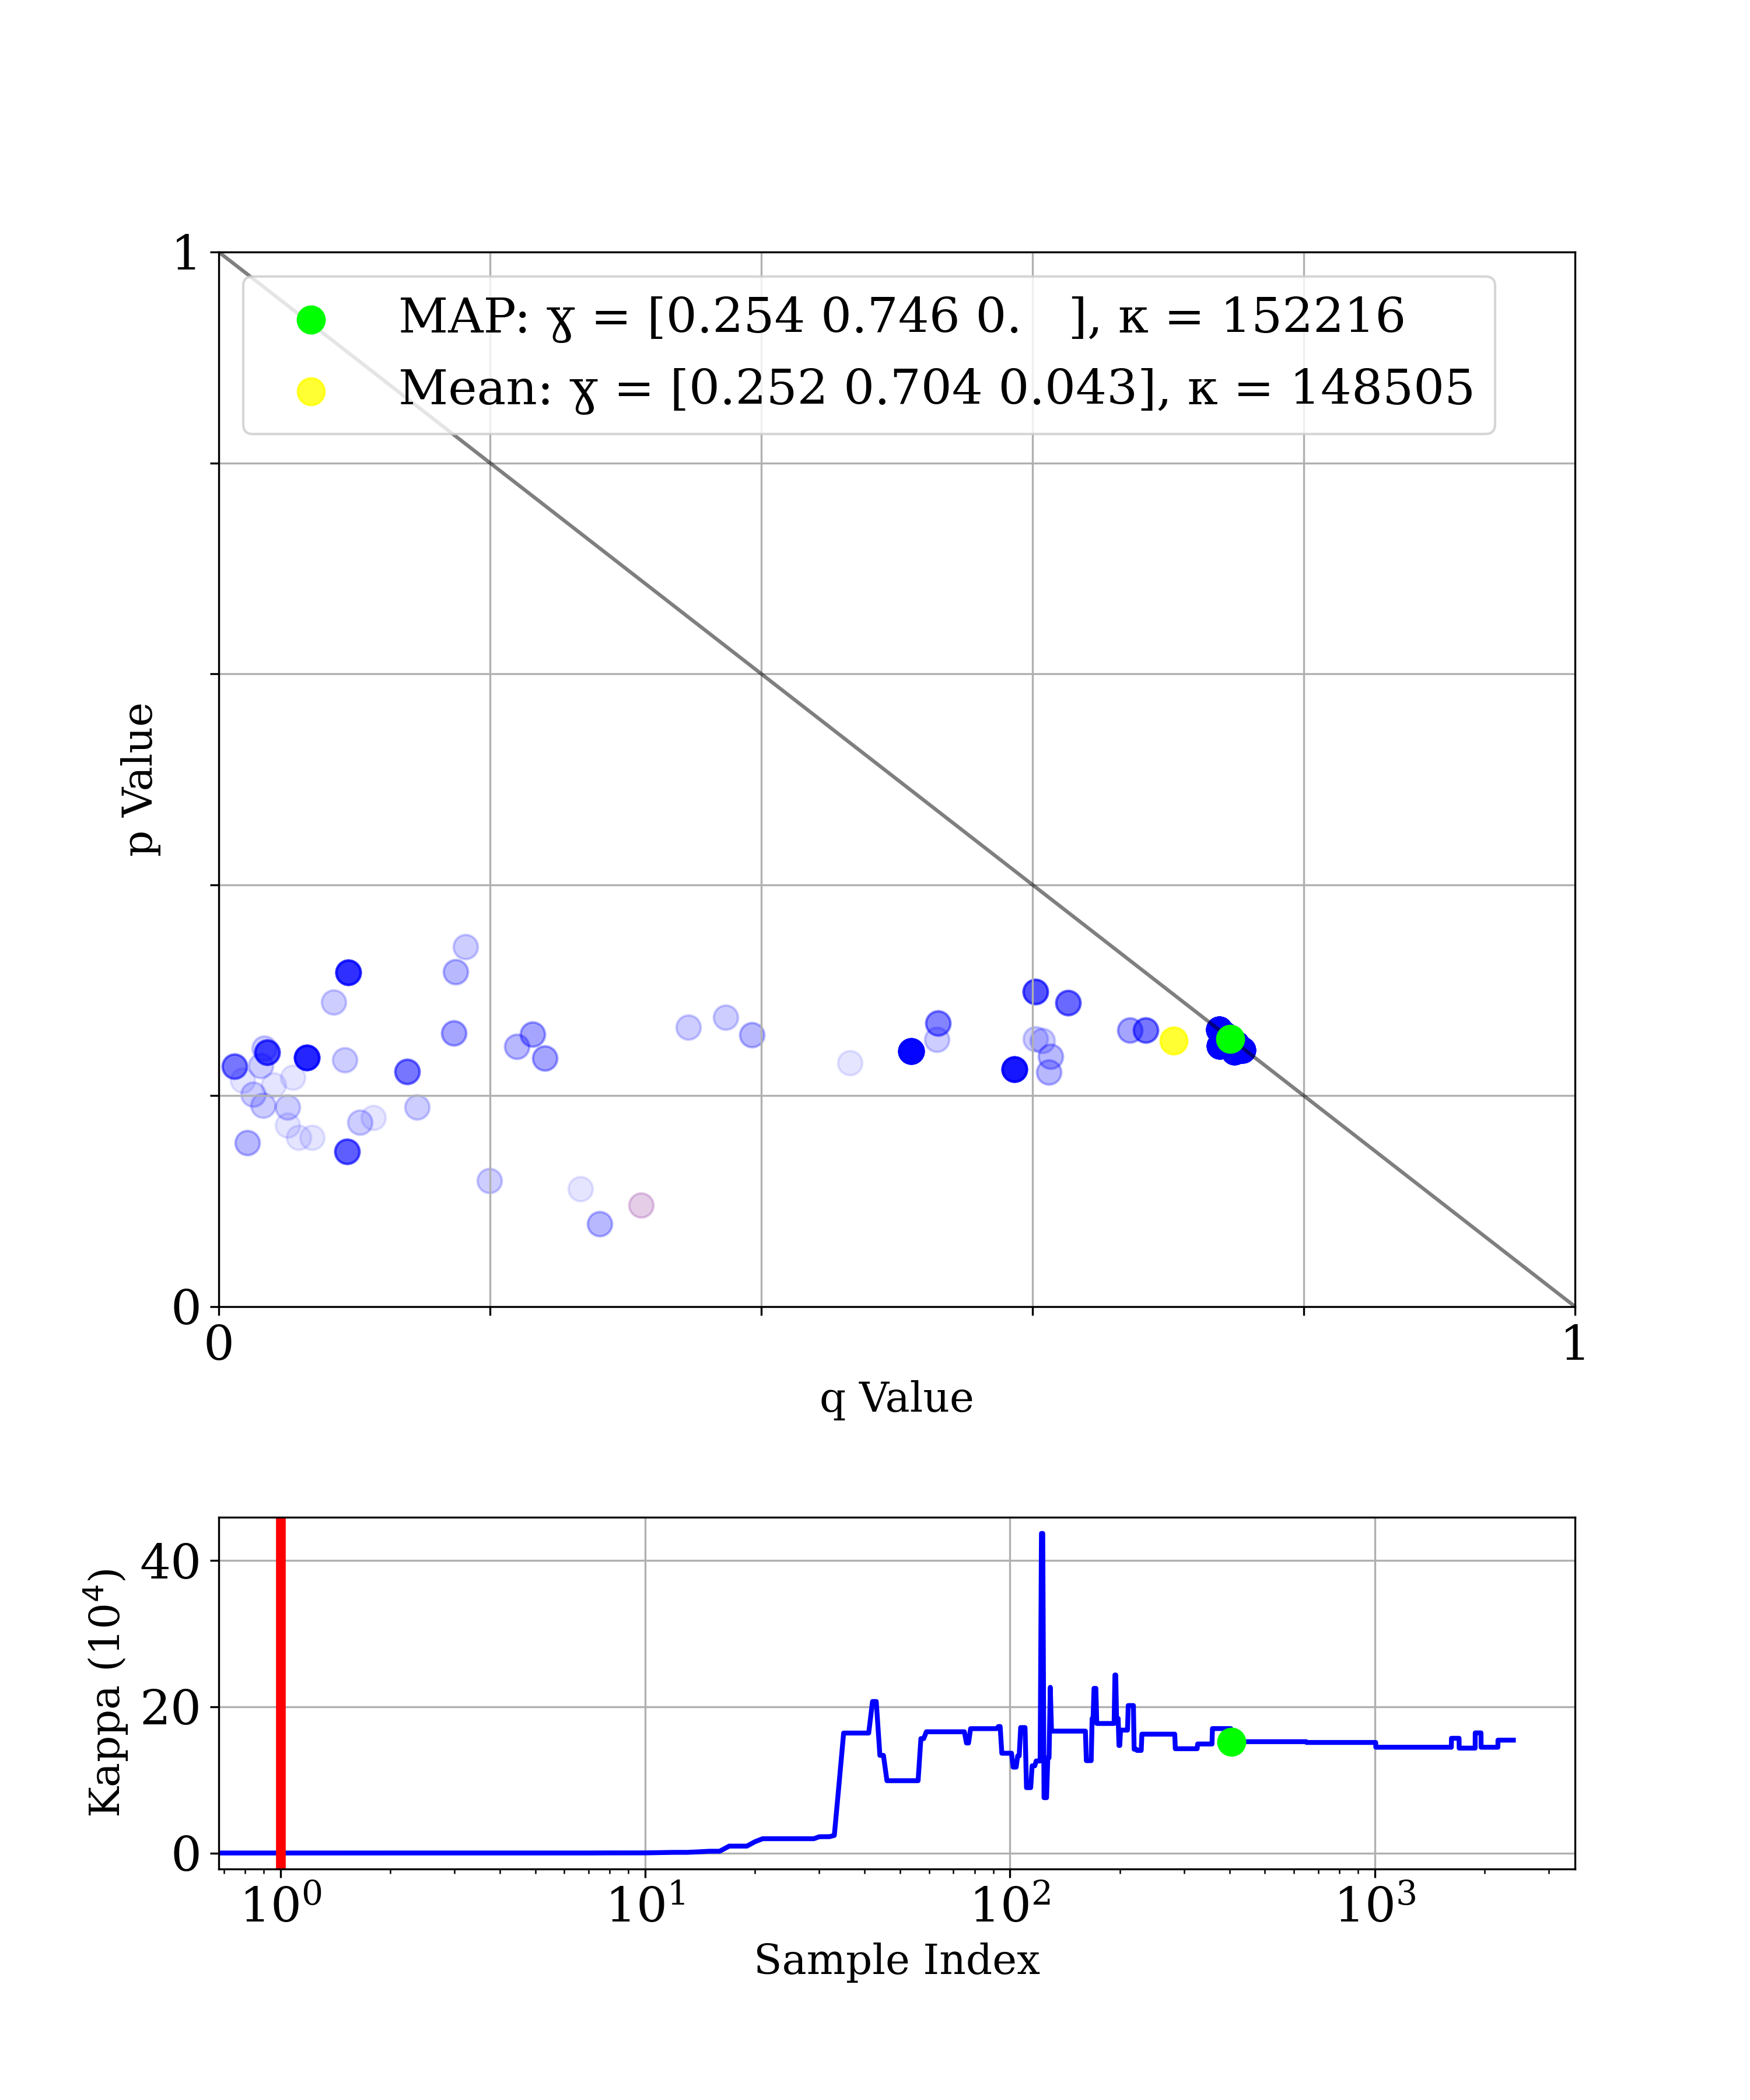

In [181]:
# Function to plot the samples with the specified index
plt.close()
plt.rcParams.update({'font.size': 20})
fig3, ax3 = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [3, 1]}, dpi=300)
fig3.subplots_adjust(hspace=0.3)
fig3.set_size_inches(10, 12)

def plot_sample(sample_index):
    sample_index = int(np.round(np.exp(sample_index)))

    samps = np.concatenate((burnin_samples_array, samples_array))
    kappas = np.concatenate((burnin_samples_kappa, samples_kappa))
    
    ax = ax3[0]
    
    ax.cla()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('q Value', fontsize ='17', va='top')
    ax.set_ylabel('p Value', fontsize='17')
    ax.grid(True)
    ax.set_xticklabels([0,'', '','','', 1])
    ax.set_yticklabels([0,'', '','','', 1])

    maps = np.zeros(len(map_estimate_list) - sample_index)
    for i, entry in zip(np.arange(len(map_estimate_list) - sample_index), map_estimate_list[sample_index:]):
        maps[i] = map_estimate_list[i][1]
    idx = np.argmax(maps)
    map = map_estimate_list[idx]
    evidence = map[1]
    kappa_map = map[0][0]
    map = map[0][1:]
    ax.scatter(map[1], map[0], s=120, c='lime', alpha=1, label=f'MAP: ɣ = {np.round(map,3)}, κ = {int(kappa_map)}', zorder=5)
    
    ax.scatter(samps[:sample_index, 1], samps[:sample_index, 0], s=100, c='red', alpha=0.1)#, label=f'Sample {sample_index}')
    ax.scatter(samps[sample_index:, 1], samps[sample_index:, 0], s=100, c='blue', alpha=0.1)
    
    # plot mean    
    curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
    curr_kappa_mean = int(np.mean(kappas[sample_index:]))
    ax.scatter(curr_mean[1], curr_mean[0], s=120, c='yellow', alpha=0.8, label=f'Mean: ɣ = {curr_mean}, κ = {curr_kappa_mean}')
    
    ax.legend(loc='upper left', fontsize="20")
    ax.plot([0, 1], [1, 0], transform=ax.transAxes, c='black', alpha=0.5)

    ax_2 = ax3[1]
    ax_2.cla()
    ax_2.plot(range(len(kappas)), kappas, color='blue', lw=2)
    #ax_2.scatter(sample_index, kappas[sample_index], s=80, c='red', alpha=1)
    ax_2.scatter(idx, kappa_map, s=120, c='lime', alpha=1, zorder=5)
    ax_2.axvline(x=sample_index, color='red', linestyle='solid', lw=4)
    ax_2.set_xscale('log')

    # Set labels and title
    ax_2.set_xlabel('Sample Index', fontsize='17')
    ax_2.set_ylabel('Kappa (10$^4$)', fontsize='17')
    ax_2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/10000), ',')))
    ax_2.grid(True)
    
    return 0

# Create an interactive plot with slider
iplt.plot(plot_sample, sample_index=(0, np.log(len(np.concatenate((burnin_samples_array, samples_array))) - 1)))

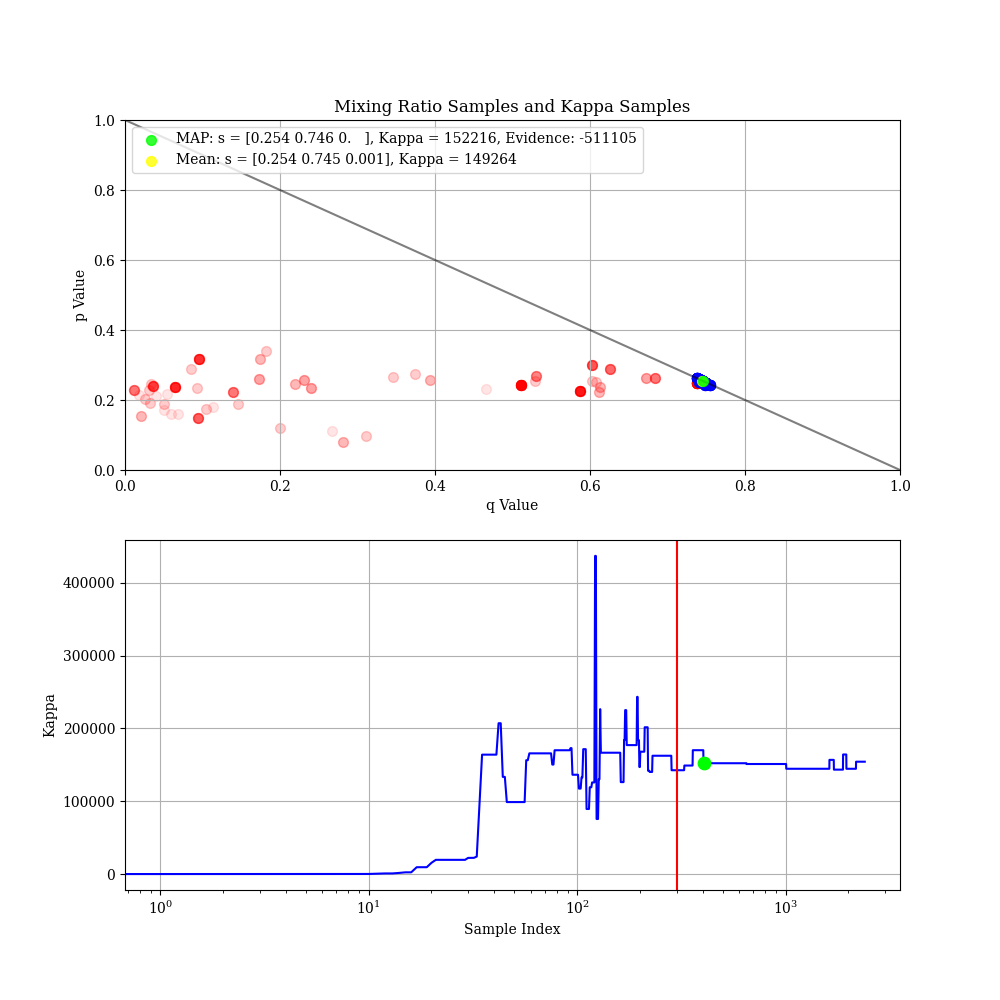

In [139]:
samps = np.concatenate((burnin_samples_array, samples_array))
kappas = np.concatenate((burnin_samples_kappa, samples_kappa))

plt.close()
fig1, ax1 = plt.subplots(nrows=2)
fig1.set_size_inches(10, 10)
ax = ax1[0]

ax.cla()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('Mixing Ratio Samples and Kappa Samples')
ax.set_xlabel('q Value')
ax.set_ylabel('p Value')
ax.grid(True)

#fixed values for fixed plot
sample_index=300
idx = 405

# plot map
map = map_estimate_list[idx]
evidence = int(map[1])
kappa_map = int(map[0][0])
map = map[0][1:]
ax.scatter(map[1], map[0], s=50, c='lime', alpha=0.8, label=f'MAP: s = {np.round(map,3)}, Kappa = {np.round(kappa_map,0)}, Evidence: {np.round(evidence,2)}', zorder=5)

# plot samples
ax.scatter(samps[:sample_index, 1], samps[:sample_index, 0], s=50, c='red', alpha=0.1)#, label=f'Sample {sample_index}')
ax.scatter(samps[sample_index:, 1], samps[sample_index:, 0], s=50, c='blue', alpha=0.1)

#plot mean
curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
curr_kappa_mean = int(np.mean(kappas[sample_index:]))
ax.scatter(curr_mean[1], curr_mean[0], s=50, c='yellow', alpha=0.8, label=f'Mean: s = {curr_mean}, Kappa = {curr_kappa_mean}')

ax.plot([0, 1], [1, 0], transform=ax.transAxes, c='black', alpha=0.5)
ax.legend(loc='upper left', fontsize="10")

# plot Kappas
ax_2 = ax1[1]
ax_2.cla()
ax_2.plot(range(len(kappas)), kappas, color='blue')
ax_2.scatter(idx, kappa_map, s=80, c='lime', alpha=1, zorder=5)
ax_2.plot()
ax_2.set_xscale('log')
ax_2.axvline(x=sample_index, color='red', linestyle='solid')

# Set labels and title
ax_2.set_xlabel('Sample Index')
ax_2.set_ylabel('Kappa')
ax_2.grid(True)

import tikzplotlib

tikzplotlib.save("mh_wikispeedia.tex") 


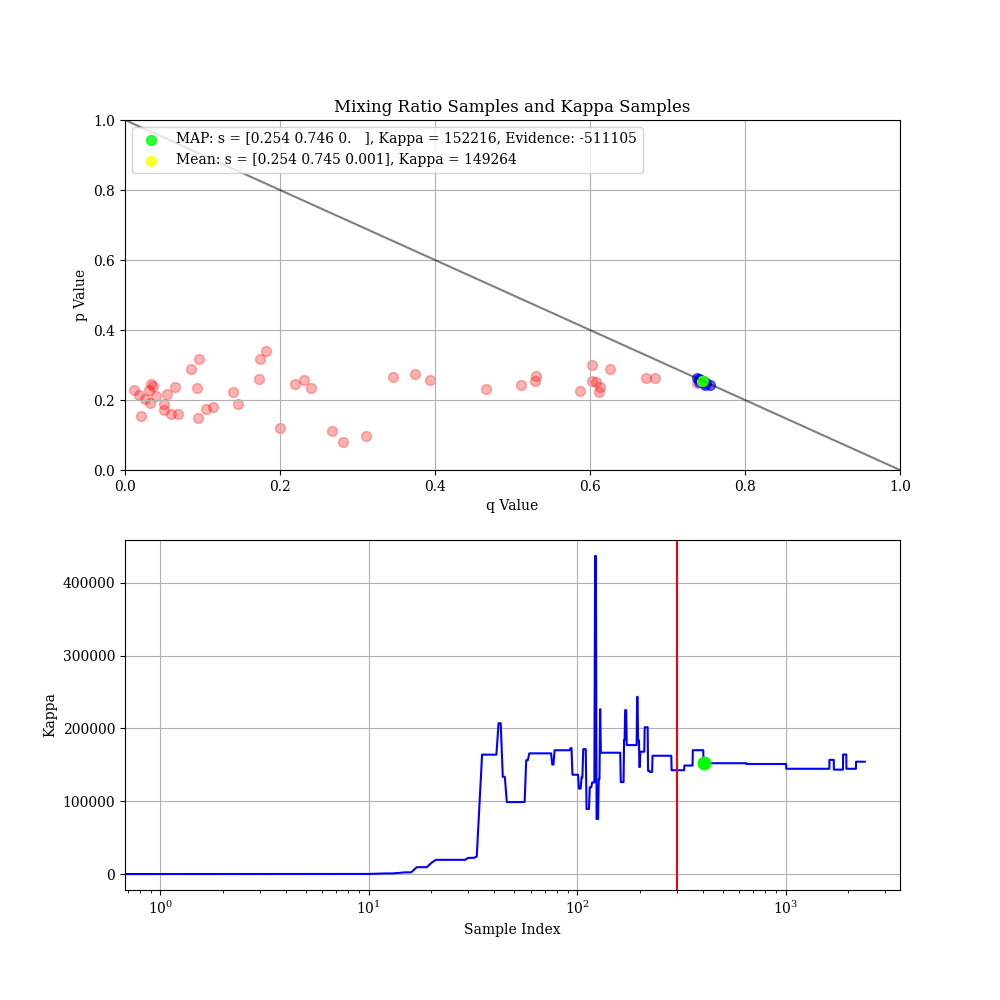

In [174]:
samps = np.concatenate((burnin_samples_array, samples_array))
kappas = np.concatenate((burnin_samples_kappa, samples_kappa))



plt.close()
fig1, ax1 = plt.subplots(nrows=2)
fig1.set_size_inches(10, 10)
ax = ax1[0]

ax.cla()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title('Mixing Ratio Samples and Kappa Samples')
ax.set_xlabel('q Value')
ax.set_ylabel('p Value')
ax.grid(True)

#fixed values for fixed plot
sample_index=300
idx = 405

# plot map
map = map_estimate_list[idx]
evidence = int(map[1])
kappa_map = int(map[0][0])
map = map[0][1:]
ax.scatter(map[1], map[0], s=50, c='lime', alpha=0.8, label=f'MAP: s = {np.round(map,3)}, Kappa = {np.round(kappa_map,0)}, Evidence: {np.round(evidence,2)}', zorder=5)

# plot samples
index=50
ax.scatter(array_acc_samples[:index, 1], array_acc_samples[:index, 0], s=50, c='red', alpha=0.3)#, label=f'Sample {sample_index}')
ax.scatter(array_acc_samples[index:, 1], array_acc_samples[index:, 0], s=50, c='blue', alpha=0.6)

#plot mean
curr_mean = np.round(np.mean(samps[sample_index:, :], axis=0), 3)
curr_kappa_mean = int(np.mean(kappas[sample_index:]))
ax.scatter(curr_mean[1], curr_mean[0], s=50, c='yellow', alpha=0.8, label=f'Mean: s = {curr_mean}, Kappa = {curr_kappa_mean}')

ax.plot([0, 1], [1, 0], transform=ax.transAxes, c='black', alpha=0.5)
ax.legend(loc='upper left', fontsize="10")

# plot Kappas
ax_2 = ax1[1]
ax_2.cla()
ax_2.plot(range(len(kappas)), kappas, color='blue')
ax_2.scatter(idx, kappa_map, s=80, c='lime', alpha=1, zorder=5)
ax_2.plot()
ax_2.set_xscale('log')
ax_2.axvline(x=sample_index, color='red', linestyle='solid')

# Set labels and title
ax_2.set_xlabel('Sample Index')
ax_2.set_ylabel('Kappa')
ax_2.grid(True)

import tikzplotlib

tikzplotlib.save("mh_wikispeedia.tex") 
